In [1]:
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set up

In [2]:
# set up auto load
%load_ext autoreload
%autoreload 2

In [3]:
from load_data import *
from model import *

plt.rcParams['font.family'] = 'serif'
sns.set_style("darkgrid")

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print('PyTorch CUDA is available?', torch.cuda.is_available())

PyTorch CUDA is available? True


In [4]:
train_ticker_strings = ["AAPL", "AMZN", "CAT", "GOOG", "HSBC", "KO", "JPM", "PCG", "ABB", "BAC", "BP"]
# train_ticker_strings = ["GOOG", "T", "ORCL", "TSM", "VZ", "INTC", "CSCO"]
look_back = 60
train_data_loader = get_data_loader(TransformerMultiFeaturesFilteredDataset, train_ticker_strings, look_back=look_back)
print("train data size (in batches):", len(train_data_loader))

train data size (in batches): 246


In [5]:
train_small_data_loader = get_data_loader(TransformerMultiFeaturesFilteredDataset, train_ticker_strings[:1], look_back=look_back)
print("train small data size (in batches):", len(train_small_data_loader))

train small data size (in batches): 25


In [9]:
input_dim = 4
hidden_dim = 256
num_layers = 6
output_dim = 1
num_epochs = 50
lr = 0.01
dim_feedforward = 1024
nhead = 2
dropout=0.1
hist = np.zeros(num_epochs)

model = Transformer(
    look_back,
    input_dim,
    hidden_dim=hidden_dim,
    dim_feedforward=dim_feedforward,
    nhead=nhead,
    num_encoder_layers=num_layers,
    dropout=dropout,
    device=device
)
model = model.to(device)

w_loss = 1
loss_fn_mse = torch.nn.MSELoss()
loss_fn_bin = torch.nn.CrossEntropyLoss()

optimiser = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

Transformer(
  (encoder): Encoder(
    (encoder_layers): ModuleList(
      (0-5): 6 x EncoderBlock(
        (multi_head): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (layer_norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (layer_norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=4, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=4, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (cross_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (layer_norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=4, out_features=256, bias=True)
  (relu): ReLU()
 

In [10]:
# try model on small dataset
for t in range(num_epochs):
    total_loss = 0
    total_mse = 0
    total_bin = 0
    # y_train_preds = []
    for X_train, y_train in train_small_data_loader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward pass
        y_train_pred = model(X_train)
        # binarize pred and y for binary loss func
        y_train_pred_bin = y_train_pred.clone()
        y_train_pred_bin[(y_train_pred-X_train[:,-1:,0])>0] = 1
        y_train_pred_bin[(y_train_pred-X_train[:,-1:,0])<=0] = 0
        y_train_bin = y_train.clone()
        y_train_bin[(y_train-X_train[:,-1:,0])>0] = 1
        y_train_bin[(y_train-X_train[:,-1:,0])<=0] = 0

        # y_train_preds.extend(y_train_pred)

        loss_mse = (1-w_loss)*loss_fn_mse(y_train_pred.flatten(), y_train.flatten().to(device))
        loss_bin = w_loss*loss_fn_bin(y_train_pred_bin.flatten(), y_train_bin.to(device).flatten())
        #print("!!!!!", loss_bin)
        loss = loss_mse + loss_bin

        total_mse += loss_mse.item()
        total_bin += loss_bin.item()
        total_loss += loss_mse.item()+loss_bin.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()
        # Update parameters
        optimiser.step()

    hist[t] = total_loss
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "Total Loss: ", total_loss, "MSE Loss: ", total_mse, "Binary Loss: ", total_bin)

Epoch  10 Total Loss:  1547.8589868545532 MSE Loss:  0.0 Binary Loss:  1547.8589868545532
Epoch  20 Total Loss:  1552.9896907806396 MSE Loss:  0.0 Binary Loss:  1552.9896907806396
Epoch  30 Total Loss:  1551.3643550872803 MSE Loss:  0.0 Binary Loss:  1551.3643550872803
Epoch  40 Total Loss:  1549.2752590179443 MSE Loss:  0.0 Binary Loss:  1549.2752590179443


In [12]:
input_dim = 4
hidden_dim = 256
num_layers = 6
output_dim = 1
num_epochs = 300
lr = 0.001
dim_feedforward = 1024
nhead = 2
dropout=0.1
hist = np.zeros(num_epochs)

model = Transformer(
    look_back,
    input_dim,
    hidden_dim=hidden_dim,
    dim_feedforward=dim_feedforward,
    nhead=nhead,
    num_encoder_layers=num_layers,
    dropout=dropout,
    device=device
)
model = model.to(device)
w_loss = 0
loss_fn_mse = torch.nn.MSELoss()
loss_fn_bin = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)


# train the model
# try model on small dataset
for t in range(num_epochs):
    total_loss = 0
    total_mse = 0
    total_bin = 0
    # y_train_preds = []
    for X_train, y_train in train_data_loader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward pass
        y_train_pred = model(X_train)
        # binarize pred and y for binary loss func
        y_train_pred_bin = y_train_pred.clone()
        y_train_pred_bin[(y_train_pred-X_train[:,-1:,0])>0] = 1
        y_train_pred_bin[(y_train_pred-X_train[:,-1:,0])<=0] = 0
        y_train_bin = y_train.clone()
        y_train_bin[(y_train-X_train[:,-1:,0])>0] = 1
        y_train_bin[(y_train-X_train[:,-1:,0])<=0] = 0

        # y_train_preds.extend(y_train_pred)

        loss_mse = (1-w_loss)*loss_fn_mse(y_train_pred.flatten(), y_train.flatten().to(device))
        loss_bin = w_loss*loss_fn_bin(y_train_pred_bin.flatten(), y_train_bin.to(device).flatten())
        #print("!!!!!", loss_bin)
        loss = loss_mse + loss_bin

        total_mse += loss_mse.item()
        total_bin += loss_bin.item()
        total_loss += loss_mse.item()+loss_bin.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()
        # Update parameters
        optimiser.step()

    hist[t] = total_loss
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "Total Loss: ", total_loss, "MSE Loss: ", total_mse, "Binary Loss: ", total_bin)

Epoch  10 Total Loss:  15.307920506224036 MSE Loss:  15.307920506224036 Binary Loss:  0.0
Epoch  20 Total Loss:  14.478596301749349 MSE Loss:  14.478596301749349 Binary Loss:  0.0
Epoch  30 Total Loss:  13.625552985817194 MSE Loss:  13.625552985817194 Binary Loss:  0.0
Epoch  40 Total Loss:  13.146657599136233 MSE Loss:  13.146657599136233 Binary Loss:  0.0
Epoch  50 Total Loss:  12.488585194572806 MSE Loss:  12.488585194572806 Binary Loss:  0.0
Epoch  60 Total Loss:  12.314582210034132 MSE Loss:  12.314582210034132 Binary Loss:  0.0
Epoch  70 Total Loss:  12.308808322995901 MSE Loss:  12.308808322995901 Binary Loss:  0.0
Epoch  80 Total Loss:  12.146348651498556 MSE Loss:  12.146348651498556 Binary Loss:  0.0
Epoch  90 Total Loss:  12.040879178792238 MSE Loss:  12.040879178792238 Binary Loss:  0.0
Epoch  100 Total Loss:  12.053224794566631 MSE Loss:  12.053224794566631 Binary Loss:  0.0
Epoch  110 Total Loss:  12.015438651666045 MSE Loss:  12.015438651666045 Binary Loss:  0.0
Epoch  1

Text(0.5, 1.0, 'Loss')

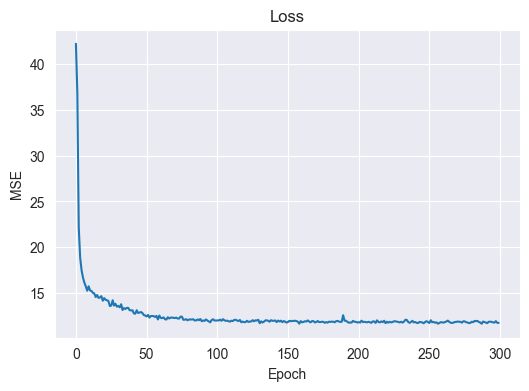

In [13]:
figure, axes = plt.subplots(figsize=(6, 4))
plt.plot(range(num_epochs), hist)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Loss")

In [14]:
test_ticker_string = ['MSFT']
test_data_loader = get_data_loader(TransformerMultiFeaturesFilteredDataset, test_ticker_string, look_back=look_back, shuffle=False, train=False)
predicted_ticker = test_ticker_string[0]
print("test data sze (in batches):", len(test_data_loader))

test data sze (in batches): 23


In [16]:
# make predictions
y_tests = []
y_test_preds = []
for X_test, y_test in test_data_loader:
    X_test = X_test.to(device)
    y_tests.extend(y_test)
    pred = model(X_test)
    pred = pred.detach().cpu()
    y_test_preds.extend(pred)

# y_tests = test_data_loader.dataset.df['Adj Close'][look_back:].values
y_tests = torch.stack(y_tests).cpu().detach().numpy()
y_test_preds = torch.stack(y_test_preds).cpu().detach().numpy()

# calculate root mean squared error
testScore = (mean_squared_error(y_tests, y_test_preds))
print('Test Score: %.5f MSE' % (testScore))

y_tests = test_data_loader.dataset.df['Adj Close']
y_tests = np.array(y_tests)
# N, 1 -> N, 1, D
y_test_preds = np.expand_dims(y_test_preds, axis=2).repeat(input_dim, axis=2)
# N, 1
y_test_preds = test_data_loader.dataset.invert_transform(y_test_preds)
test_price_score = np.sqrt(mean_squared_error(y_tests, y_test_preds))
print('Test Price Score: %.2f RMSE' % (test_price_score))

Test Score: 0.04953 MSE
Test Price Score: 0.80 RMSE


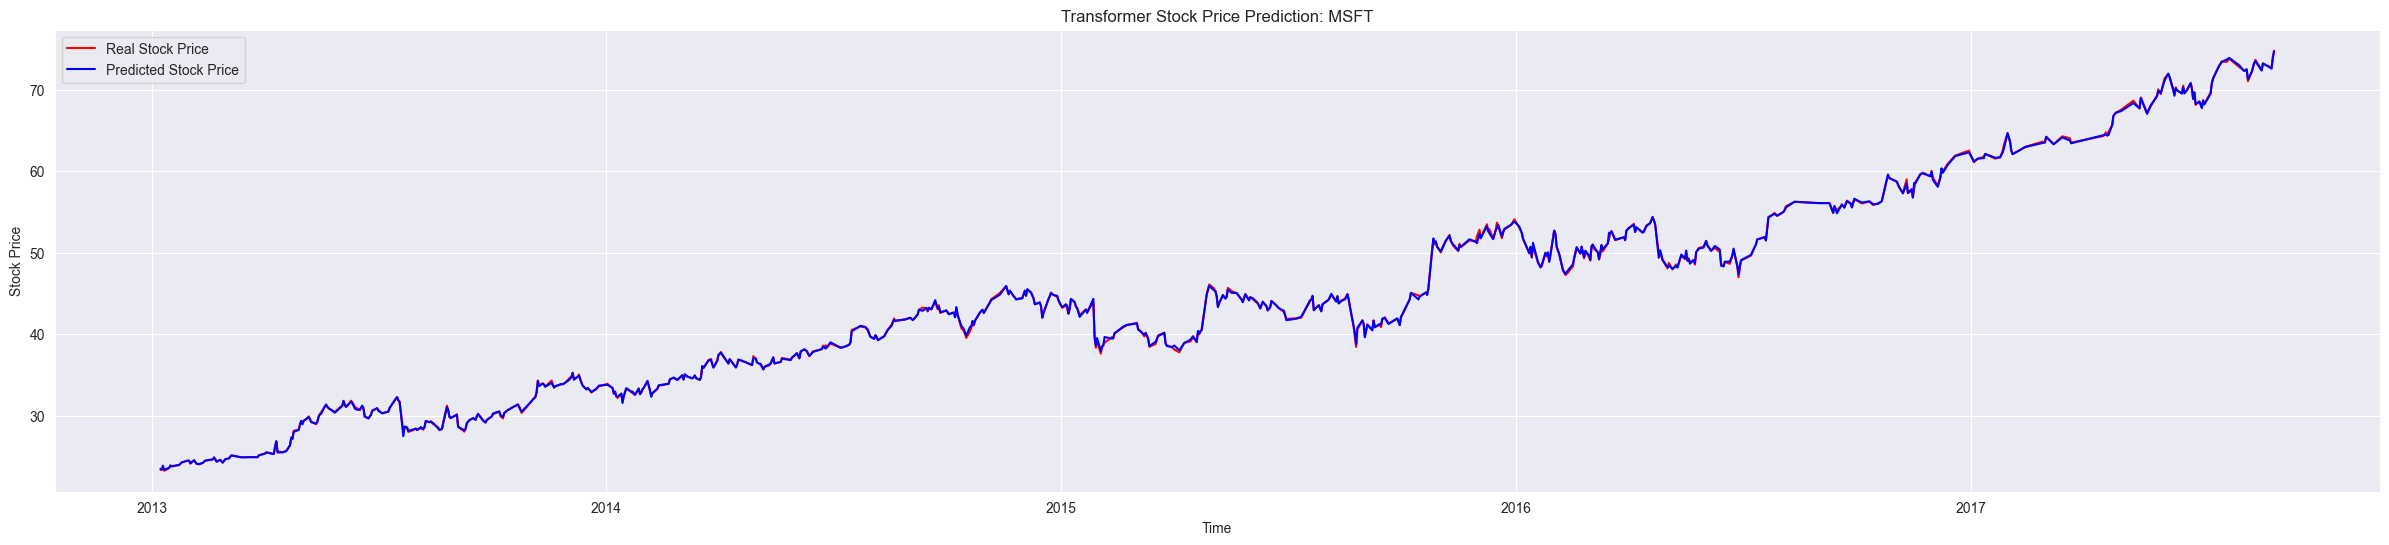

In [23]:
# Visualising the results
figure, axes = plt.subplots(figsize=(30, 6))

axes.xaxis_date()

df = test_data_loader.dataset.df

axes.plot(df.index[1:], y_tests[:-1], color = 'red', label = 'Real Stock Price')
axes.plot(df.index[1:], y_test_preds[1:,0], color = 'blue', label = 'Predicted Stock Price')
# axes.plot(df.index, y_tests, color = 'red', label = 'Real Stock Price')
# axes.plot(df.index, y_test_preds[:,0], color = 'blue', label = 'Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title(f'Transformer Stock Price Prediction: {predicted_ticker}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig(f'./plots/transformer2_pred_{predicted_ticker}.png')
plt.show()

In [20]:
correct_pred = 0
incorrect_pred = 0
for i in range(1, len(y_tests)):
    if (y_tests[i] - y_tests[i-1]) * (y_test_preds[i] - y_tests[i-1]) > 0:
        correct_pred += 1
    else:
        incorrect_pred += 1

print("Accuracy of predicting rise/drop: ", correct_pred / (correct_pred + incorrect_pred))

Accuracy of predicting rise/drop:  0.5131761442441054


In [48]:
save_path = './models/transformer_2_model.pth'

# Save the model to file
torch.save(model.state_dict(), save_path)